making a plot for two different species

In [1]:
import pandas as pd
import numpy as np
import json
import os
import sys
sys.path.append('../')
import datasets
import utils
import torch
import models
import matplotlib.pyplot as plt

/Users/filipdorm/opt/anaconda3/envs/sinr_icml_og/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
HIGH_RES = True
THRESHOLD = 0.5
DISABLE_OCEAN_MASK = False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TAXA = 13270
SET_MAX_CMAP_TO_1 = False

In [3]:
# load model
train_params = torch.load('../pretrained_models/model_an_full_input_enc_sin_cos_hard_cap_num_per_class_1000.pt', map_location='cpu')
model = models.get_model(train_params['params'])
model.load_state_dict(train_params['state_dict'], strict=True)
model = model.to(DEVICE)
model.eval()

ResidualFCNet(
  (class_emb): Linear(in_features=256, out_features=47375, bias=False)
  (feats): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=

In [4]:
#load reference from iucn
with open(os.path.join('../data/eval/iucn/', 'iucn_res_5.json'), 'r') as f:
            data = json.load(f)

In [5]:
if train_params['params']['input_enc'] in ['env', 'sin_cos_env']:
    raster = datasets.load_env()
else:
    raster = None
enc = utils.CoordEncoder(train_params['params']['input_enc'], raster=raster)

In [6]:
obs_locs = np.array(data['locs'], dtype=np.float32)
obs_locs = torch.from_numpy(obs_locs).to('cpu')
loc_feat = enc.encode(obs_locs)

In [7]:
loc_feat.shape

torch.Size([2016842, 4])

In [8]:
class_of_interest = train_params['params']['class_to_taxa'].index(TAXA)

In [9]:
# make prediction
with torch.no_grad():
    preds = model(loc_feat, return_feats=False, class_of_interest=class_of_interest).cpu().numpy()

In [13]:
copy_preds = preds.copy()

In [14]:
np.mean(copy_preds)

0.003350218

In [15]:
species_locs = data['taxa_presence'].get(str(TAXA))

In [17]:
import geopandas as gpd
df = gpd.read_file('../continent-poly/North America.shp')

In [39]:
test = np.array(data['locs'])
plot_array = test[species_locs]

In [42]:
plot_array

array([[-98.88773346,  25.9771862 ],
       [-98.26985931,  31.33932304],
       [-99.63832092,  23.95809746],
       ...,
       [-79.79305267,  34.68382263],
       [-81.30400085,  47.18034363],
       [-71.67185974,  41.93505478]])

In [45]:
len(plot_array)

20339

In [63]:
points = plot_array[0:200]

In [89]:
from sklearn.neighbors import KernelDensity
def kd_contour(points, b = 0.4):
    # Fit a kernel density estimator
    kde = KernelDensity(bandwidth=b)
    kde.fit(points)

    # Create a grid of points to evaluate the KDE
    x_min, x_max = points[:, 0].min() - 0.1, points[:, 0].max() + 0.1
    y_min, y_max = points[:, 1].min() - 0.1, points[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    z = np.exp(kde.score_samples(xy))
    zz = z.reshape(xx.shape)

    return xx, yy, zz

In [99]:
thresholds = [0.02,0.1,0.5]
mask1_wt = copy_preds>thresholds[0]
plot_threhs1 = test[mask1_wt]

mask2 = copy_preds>thresholds[1]
plot_threhs2_wt = test[mask2]

mask3 = copy_preds>thresholds[2]
plot_threhs3_wt = test[mask3]

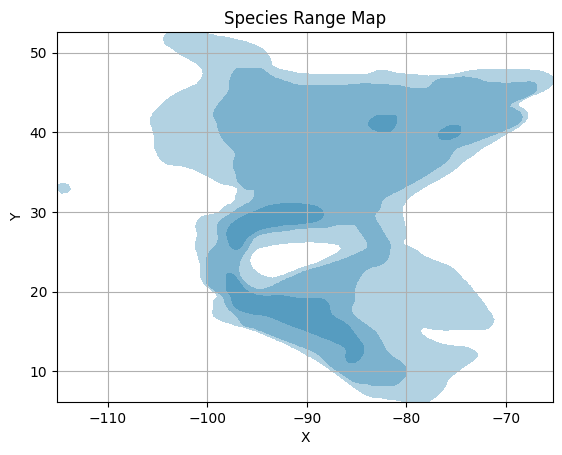

In [127]:
xx, yy, zz=kd_contour(plot_threhs1, b=0.4)
contour_level = 0.1 * zz.max()  # Adjust the contour level threshold as needed
plt.contourf(xx, yy, zz, levels=[contour_level, zz.max()], colors="#006BA2", alpha=0.3)

xx, yy, zz=kd_contour(plot_threhs2_wt, b=0.4)
contour_level = 0.1 * zz.max()  # Adjust the contour level threshold as needed
plt.contourf(xx, yy, zz, levels=[contour_level, zz.max()], colors="#006BA2", alpha=0.3)

xx, yy, zz=kd_contour(plot_threhs3_wt, b=0.4)
contour_level = 0.1 * zz.max()  # Adjust the contour level threshold as needed
plt.contourf(xx, yy, zz, levels=[contour_level, zz.max()], colors="#006BA2", alpha=0.3)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Species Range Map')
plt.grid(True)
plt.show()

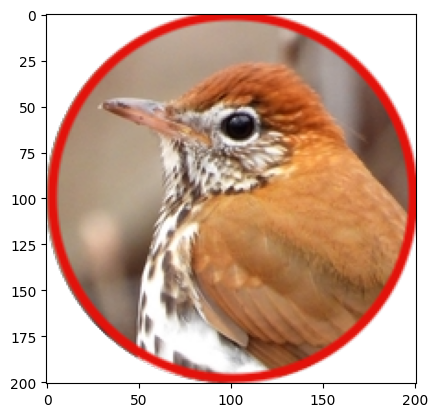

In [173]:
import matplotlib.image as image
file = './animal_imags/wood_thrush.png'
pic = image.imread(file)
plt.imshow(pic)

/var/folders/pp/c6m9_85s5rd16hbzmflk4b9r0000gn/T/ipykernel_36144/2110966384.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


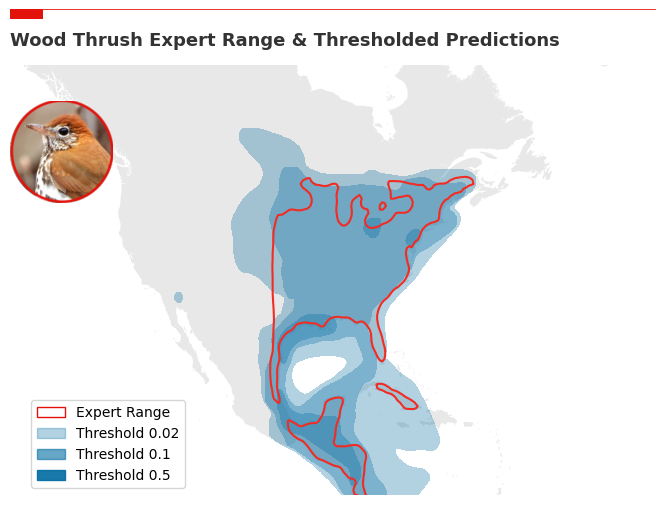

In [190]:
import matplotlib.patches as mpatches
from my_plot import set_size
# Setup plot size.
fig, ax = plt.subplots(figsize = set_size(597.50787))

df.plot(ax=ax,color="lightgray", alpha=0.5)
ax.set_xlim(-140, -40)
ax.set_ylim(10, 60)
ax.set_xticks([])
ax.set_yticks([])

newax = fig.add_axes([0.12, 0.6, 0.2, 0.2], anchor='NW', zorder=1)
newax.imshow(pic)
newax.axis('off')

#plot outline
xx, yy, zz=kd_contour(plot_array, b=0.4)
ax.contour(xx, yy, zz, levels=1, colors="#F12C24")

xx, yy, zz=kd_contour(plot_threhs1, b=0.4)
contour_level = 0.1 * zz.max()  # Adjust the contour level threshold as needed
ax.contourf(xx, yy, zz, levels=[contour_level, zz.max()], colors="#006BA2", alpha=0.3)

xx, yy, zz=kd_contour(plot_threhs2_wt, b=0.4)
contour_level = 0.1 * zz.max()  # Adjust the contour level threshold as needed
ax.contourf(xx, yy, zz, levels=[contour_level, zz.max()], colors="#006BA2", alpha=0.3)

xx, yy, zz=kd_contour(plot_threhs3_wt, b=0.4)
contour_level = 0.1 * zz.max()  # Adjust the contour level threshold as needed
ax.contourf(xx, yy, zz, levels=[contour_level, zz.max()], colors="#006BA2", alpha=0.3)


#Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right','left', 'bottom']].set_visible(False)

# Add in line and tag
ax.plot([0.12, .9],                  # Set width of line
        [.98, .98],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,.98),                 # Set location of rectangle by lower left corder
                           0.04,                       # Width of rectangle
                           -0.02,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))

# Add in title and subtitle
ax.text(x=0.12, y=.91, s="Wood Thrush Expert Range & Thresholded Predictions", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(facecolor='none', label='Expert Range', edgecolor='#E3120B')
handles.append(patch) 
patch = mpatches.Patch(label='Threshold 0.02', color="#006BA2", alpha=0.3)
handles.append(patch) 
patch = mpatches.Patch(label='Threshold 0.1', color="#006BA2", alpha=0.6)
handles.append(patch) 
patch = mpatches.Patch(label='Threshold 0.5', color="#006BA2", alpha=0.9)
handles.append(patch) 
# plot the legend
ax.legend(handles=handles, loc='lower left')

plt.tight_layout()
plt.savefig('./plots/wood_thrush.pdf')
